## This file plots the evaluation results for hyperparameter tuning

When the default hyperparameter tuning script has been used, for each combination of hyperparameters, the models have been trained 10 times (10 training episodes), after which they have been evaluated 5 times (5 evaluation episodes). The score that is used to compare the performance of different hyperparameter combinations is the average cumulative return (total profit) over the evaluation episodes. This score and its standard error are reported for each edge server agent in the environment, as well as the whole edge platform (the profit of the edge platform = cumulative returns summed over agents).

In [1]:
# Requirements
import numpy as np
import pandas as pd
import itertools
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from os import listdir, makedirs
from os.path import join, exists

## Functions for result parsing and plotting

In [2]:
def plot_hyperparam_tuning_results(hyperparams, partial_output_dir, save_figs=False, fpath=None):
    '''
    Plots the score of each hyperparameter combination for all simulation scenarios in the provided output.
    
    Two figures are plotted for each simulation scenario. The first figure depicts the average cumulative return of the 
    whole edge platform and its standard error for each hyperparameter combination. The second figure depicts the same 
    metrics (average cumulative return + standard error) for each edge agent and each hyperparameter combination.
    
    The figures can be saved by setting the argument 'save_figs' as True. Figures are saved in PDF format with the file
    name '<scenario_name>_htuning.pdf'. It is possible to specify a folder for saving the figures in the argument 'fpath'. 
    If the provided path has folders that do not exist, they will be created.
    
    It is assumed that the path to the result folder for each hyperparameter combination is exactly the same up to the 
    point specified by the argument 'partial_output_folder', after which a string of numbers that specifies the used
    hyperparameter combination has been added to the folder name. The length of the number string is equal to the 
    number of hyperparameters, and the number itself gives the index of the used hyperparameter value in the corresponding 
    value list (hyperparameter names and the corresponding value lists must be given as an ordered dictionary in the argument 
    'hyperparams').
    For example, if there are two hyperparameters with two possible values, all possible extensions to 'partial_output_folder'
    are '00', '01', '10', and '11'. When the path in 'partial_output_folder' is extended with '01', the resulting folder 
    contains the evaluation output when the first hyperparameter had been set to use the first value in the corresponding 
    value list, and the second hyperparameter had been set to use the second value in the corresponding value list.
    
    Args:
        hyperparams (dict): A dictionary where the keys are hyperparameter names and each value is a list of all possible
                            values for the corresponding hyperparameter.
        partial_output_dir (str): Partial path to the output folder, which is shared by all hyperparameter combinations.
                                  This is extended with a number string that specifies the hyperparameter combination used
                                  to get the output in the resulting folder.
        save_figs (bool): Whether to save the plots (in PDF format) or not. Default is False.
        fpath (str): A path to a folder where the figures will be saved. By default, figures are saved to the current 
                     working directory.
        
    Returns:
        Nothing.
    '''
    index_lists = [[i for i in range(len(value_list))] for value_list in hyperparams.values()]
    hyperparam_combos = [''.join(str(value) for value in combo_tuple) for combo_tuple in itertools.product(*index_lists)]
    hyperparam_labels = [''.join(hyperparam_name + ': ' + str(value_list[combo_tuple[i]]) + '\n' 
                                 for i, (hyperparam_name, value_list) in enumerate(hyperparams.items())
                                ) for combo_tuple in itertools.product(*index_lists)]
    hindex = [i for i in range(len(hyperparam_labels))]
    
    results_per_scenario, info = parse_hyperparam_eval_results_per_scenario(hyperparam_combos, partial_output_dir)
    
    if results_per_scenario == None or info == None:
        return
    
    agent_labels = info['agent_names']
    
    for scenario, results in results_per_scenario.items():
        avg_total_profit = results.sum(axis=2).mean(axis=1) # Summed over agents, averaged over episodes
        avg_total_profit_SE = results.sum(axis=2).std(axis=1) / np.sqrt(info['n_of_episodes']) # standard error for mean
        avg_total_profit_lower = avg_total_profit - avg_total_profit_SE
        avg_total_profit_upper = avg_total_profit + avg_total_profit_SE
        
        avg_profit_per_agent = results.mean(axis=1) # averaged over episodes for each agent
        avg_profit_per_agent_SE = results.std(axis=1) / np.sqrt(info['n_of_episodes']) # standard error for mean
        avg_profit_per_agent_lower = avg_profit_per_agent - avg_profit_per_agent_SE
        avg_profit_per_agent_upper = avg_profit_per_agent + avg_profit_per_agent_SE
        
        
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
        fig.suptitle('Hyperparameter tuning results for scenario: {}\n'.format(scenario), fontsize=14, fontweight='bold')
        
        ax1.bar(hyperparam_labels, avg_total_profit, width=0.5, alpha=0.9)
        ax1.plot((hindex, hindex), (avg_total_profit_lower, avg_total_profit_upper), color='k', linewidth=3)
        ax1.set_title(
            'Average cumulative return for the whole edge platform over {} evaluation episodes'.format(info['n_of_episodes'])
        )
        ax1.grid(True, 'major', 'y', linewidth=0.5, c='k', alpha=0.3)
        ax1.get_yaxis().set_major_formatter(FuncFormatter(format_y_labels))
        
        for ai in range(info['n_of_agents']):
            ax2.plot(hyperparam_labels, 
                     avg_profit_per_agent[:,ai], 
                     label=agent_labels[ai],
                     marker='o'
                    )
            ax2.fill_between(hyperparam_labels, 
                             avg_profit_per_agent_lower[:,ai], 
                             avg_profit_per_agent_upper[:,ai], 
                             alpha=0.2
                            )
        
        if len(agent_labels) < 21:
            ax2.legend(loc='upper left', bbox_to_anchor=(1, 1))
        ax2.set_title(
            'Average cumulative return per agent over {} evaluation episodes'.format(info['n_of_episodes'])
        )
        ax2.grid(True, 'major', 'y', linewidth=0.5, c='k', alpha=0.3)
        ax2.get_yaxis().set_major_formatter(FuncFormatter(format_y_labels))
        
        fig.tight_layout()
        
        if save_figs:
            fname = scenario + '_htuning.pdf'
            if fpath != None:
                if not exists(fpath):
                    makedirs(fpath)
                fname = join(fpath, fname)
            
            plt.savefig(fname, format='pdf', bbox_inches='tight')
            
        plt.show()

def parse_hyperparam_eval_results_per_scenario(hyperparam_combos, partial_output_dir):
    '''
    Parses cumulative returns for every scenario, hyperparameter combination, agent and evaluation episode. The cumulative 
    returns are returned in the form of a dictionary, where the keys are simulation scenario names and values are 3D numpy 
    arrays with the shape of (n_of_hyperparam_combos, n_of_episodes, n_of_agents). 
    The value at result_dict[scenario_name][hi, ei, ai] corresponds to the cumulative return of the agent 'ai' in the 
    evaluation episode 'ei', when the hyperparameter combination 'hi' was used and the simulation scenario was 'scenario_name'.
    
    All possible hyperparameter combinations are given as a list in the argument 'hyperparam_combos'. Each combination is 
    presented as a string of numbers, and extending the path given in the argument 'partial_output_dir' with the number string 
    leads to the folder that contains the simulation results for the corresponding hyperparameter combination. It is assumed 
    that every hyperparameter combination has been tested under identical simulation settings, hence it is checked that the 
    number of episodes, the set of scenarios and the set of agents are the same for every hyperparameter output folder.
    
    Args:
        hyperparam_combos (list): A list of all possible hyperparameter combos, where each combo is a string of numbers.
        partial_output_dir (str): Partial path to the output folder, which is shared by all hyperparameter combinations.
                                  This is extended with a number string that specifies the hyperparameter combination used
                                  to get the output in the resulting folder.
    
    Returns:
        dict or NoneType: A dictionary of results per scenario, where each key is a simulation scenario name and the 
                          corresponding value is a 3D numpy array of shape (n_of_hyperparam_combos, n_of_episodes, n_of_agents).
                          None is returned if it is detected that the simulation output information for some hyperparameter 
                          combination does not match with that of the others, or that inside the result folder of one 
                          hyperparameter combination the number of scenarios in all episodes or the number of agents in all 
                          scenarios is not the same.
        dict or NoneType: A dictionary that contains information about the simulation output (number of episodes, number of 
                          agents, agent names, number of scenarios, scenario names).
                          None is returned if it is detected that the simulation output information for some hyperparameter 
                          combination does not match with that of the others, or that inside the result folder of one 
                          hyperparameter combination the number of scenarios in all episodes or the number of agents in all 
                          scenarios is not the same.
    '''
    results_per_scenario = {}
    info = None
    n_of_combos = len(hyperparam_combos)
    for hi, hcombo in enumerate(hyperparam_combos):
        output_dir = partial_output_dir + hcombo
        output_info = get_output_information(output_dir)
        if output_info == None:
            return None, None
        if info == None:
            info = output_info
            for sname in info['scenario_names']:
                results_per_scenario[sname] = np.zeros((n_of_combos, info['n_of_episodes'], info['n_of_agents']))
        else:
            for key, value in info.items():
                if info[key] != output_info[key]:
                    print('The parsed value for \"', key, 
                          '\" is different in hyperparameter tuning output folder', output_dir, 
                          'compared to other hyperparameter tuning output folders for the same simulations scenarios.')
                    return None, None
        parse_profits_from_episodes_for_hyperparam_combo(output_dir, info, results_per_scenario, hi)
    return results_per_scenario, info

def get_output_information(output_dir):
    '''
    Parses output information from an output directory. The information comprises the number of episodes (simulation runs) 
    in the output folder, the number and names of the agents in the simulation environment, as well as the number and names
    of the simulation scenarios. It is assumed that all the episodes inside the given output directory have been run with 
    the same simulation settings (the same set of agents, the same set of scenarios), hence it is checked that the number 
    of scenarios in each episode and the number of agents in each scenario is the same.
    
    Args:
        output_dir (str): A directory that contains simulation results for a number of episodes.
        
    Returns:
        dict or NoneType: A dictionary that contains information about the simulation output (number of episodes, number
                          of agents, agent names, number of scenarios, scenario names). None is returned if the given folder 
                          does not contain any episodes or if it is detected that the number of scenarios in all episodes or 
                          the number of agents in all scenarios is not the same.
    '''
    info = {}
    
    episode_folders = listdir(output_dir)
    if len(episode_folders) == 0:
        print('No episodes found in the given output folder.')
        return
    info['n_of_episodes'] = len(episode_folders)
    
    paths_to_episode_folders = [join(output_dir, efolder) for efolder in episode_folders]
    scenario_names = set()
    agent_names = set()
    n_of_scenarios = 0
    n_of_agents = 0
    
    for path_to_efolder in paths_to_episode_folders:
        log_folders = list(filter(lambda file_system_object: 'Pricelogs' in file_system_object, listdir(path_to_efolder)))
        
        if n_of_scenarios != 0 and len(log_folders) != n_of_scenarios:
            print('The number of scenarios in', path_to_efolder, 
                  'differs from the number of scenarios in other episode folders.')
            return
        else:
            n_of_scenarios = len(log_folders)
            
        scenario_names.update(list(map(lambda log_folder: '_'.join(log_folder.split('_')[2:]), log_folders)))
        paths_to_log_folders = [join(path_to_efolder, lfolder) for lfolder in log_folders]
        
        for path_to_lfolder in paths_to_log_folders:
            log_files = listdir(path_to_lfolder)
            
            if n_of_agents != 0 and len(log_files) != n_of_agents:
                print('The number of agent price log files in', path_to_lfolder, 
                      'differs from the number of agent price log files in other price log folders.')
                return
            else:
                n_of_agents = len(log_files)
            
            agent_names.update(list(map(lambda log_file: log_file.split('_')[0], log_files)))
    
    info['n_of_agents'] = n_of_agents
    info['agent_names'] = sorted(list(agent_names), key=get_agent_number_from_name)
    info['n_of_scenarios'] = n_of_scenarios
    info['scenario_names'] = sorted(list(scenario_names), key=lambda n: int(n.split('_')[-1]))
    
    return info

def parse_profits_from_episodes_for_hyperparam_combo(output_dir, output_info, results_per_scenario, hi):
    '''
    Parses the cumulative return for each agent, episode and simulation scenario for one hyperparameter combination.
    The returns are parsed into the dictionary given in the argument 'results_per_scenario', which is assumed to contain
    every possible simulation scenario as a key. The value for each key is a 3D numpy array of cumulative returns with the 
    shape (n_of_hyperparam_combos, n_of_episodes, n_of_agents). This method fills in the values at indices [hi, :, :] for 
    every simulation scenario. The argument 'hi' gives the index of the hyperparameter combination that was used to get
    the simulation output in the folder specified by the argument 'output_dir'. 
    
    Args:
        output_dir (str): A path to the folder that contains simulation output for one hyperparameter combination.
        output_info (dict): A dictionary providing general information about the simulation settings (number of episodes, 
                            number of agents, agent names, number of scenarios, scenario names).
        results_per_scenario (dict): A dictionary for saving the cumulative returns. Each key is a simulation scenario name 
                                     and the corresponding value is a 3D numpy array of shape 
                                     (n_of_hyperparam_combos, n_of_episodes, n_of_agents).
        hi (int): The index of the hyperparameter combination that was used to get the output in the folder 'output_dir'. 
    
    Returns:
        Nothing.
    '''
    paths_to_episode_folders = [join(output_dir, efolder) for efolder in listdir(output_dir)]
    
    for ei, path_to_efolder in enumerate(paths_to_episode_folders):
        log_folders = list(filter(lambda file_system_object: 'Pricelogs' in file_system_object, listdir(path_to_efolder)))
        scenario_names = list(map(lambda log_folder: '_'.join(log_folder.split('_')[2:]), log_folders))
        paths_to_log_folders = [join(path_to_efolder, lfolder) for lfolder in log_folders]
        
        for si, path_to_lfolder in enumerate(paths_to_log_folders):
            scenario = scenario_names[si]
            log_files = listdir(path_to_lfolder)
            agent_names = list(map(lambda log_file: log_file.split('_')[0], log_files))
            paths_to_log_files = [join(path_to_lfolder, log_file) for log_file in log_files]
            
            for li, path_to_lfile in enumerate(paths_to_log_files):
                agent_name = agent_names[li]
                ai = output_info['agent_names'].index(agent_name)
                cumulative_return = pd.read_csv(path_to_lfile).CumulativeProfit.iat[-1]
                results_per_scenario[scenario][hi][ei][ai] = cumulative_return

def get_agent_number_from_name(name):
    '''
    Gets the the number of an agent from its name. It is assumed that the name of an agent ends with a number that can 
    be anything between 0 and 999. E.g., for name 'dc54' the integer 54 is returned.
    
    Args:
        name (str): The name of the edge server agent.
        
    Returns:
        int: The number of the agent.
    '''
    try:
        return int(name[-3:])
    except ValueError:
        try:
            return int(name[-2:])
        except ValueError:
            return int(name[-1])

def format_y_labels(value, position):
    '''
    Formats the y-axis labels for the Matplotlib figures.
    
    Args:
        value (numpy.float64): Y label.
        position (int): The position of the label.
    
    Returns:
        str: Formatted y label.
    '''
    if value == 0:
        return str(int(value))
    return '{}M'.format(round(value * 1e-6, 3))

## Plotting the results

In [3]:
# A dictionary of the hyperparameters and their values (The dictionary is guaranteed to be ordered in Python version >= 3.7)
# The hyperparameters and their values must be given in the same order as in the hyperparameter tuning script due to the
# logic with which the results for each hyperparameter combo are saved (see the default hyperparameter tuning scripts and
# the documentation of the 'plot_hyperparam_tuning_results' function)
hyperparams = {
    'Actor lr': [0.005, 0.001, 0.0005],
    'Critic lr': [0.005, 0.001, 0.0005]
}

save_plots = True
path_to_output = '..\EISim\EISim_output\\'

### Centralized 20 servers

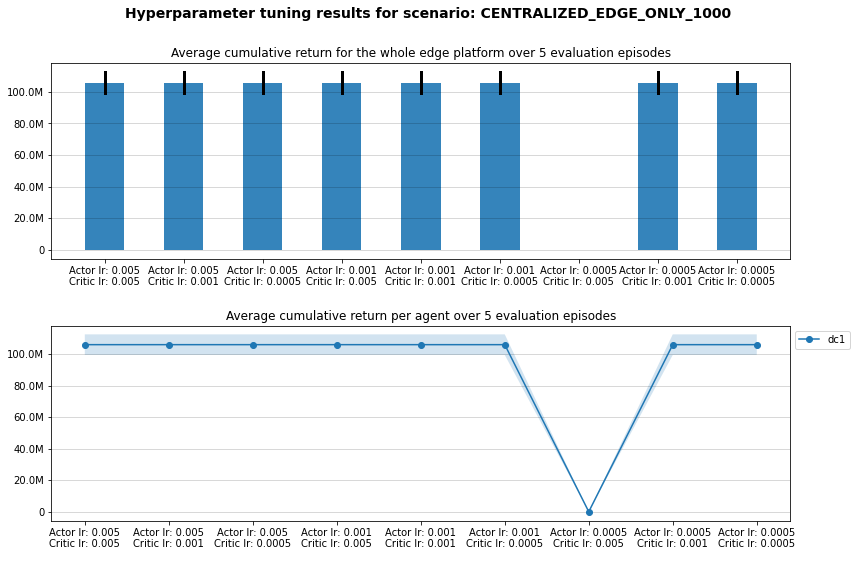

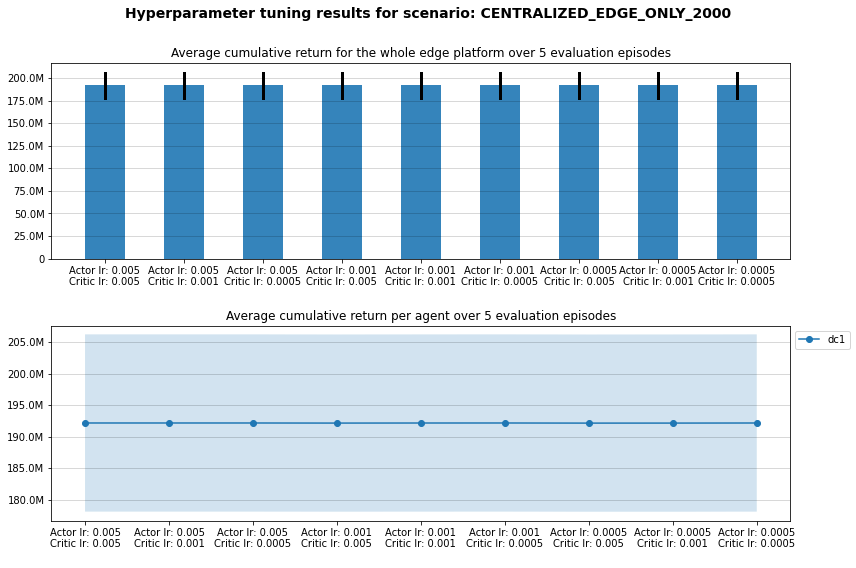

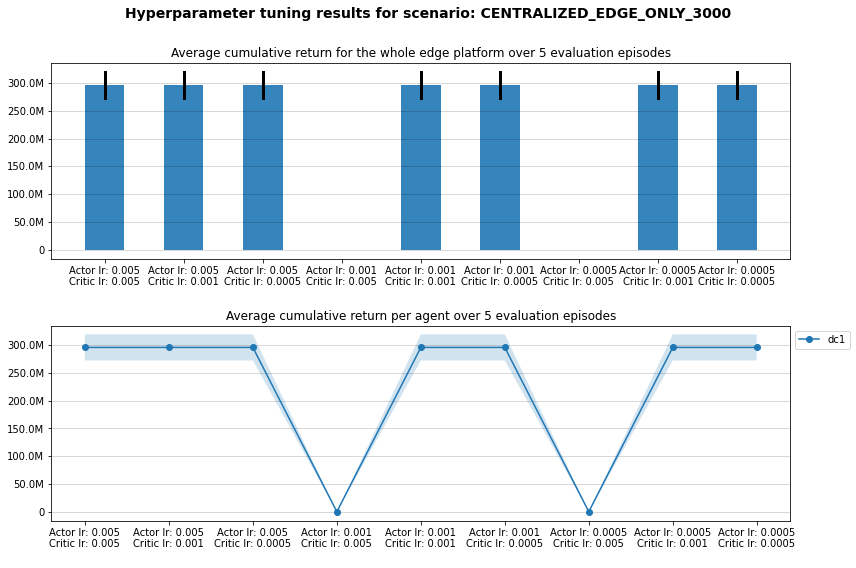

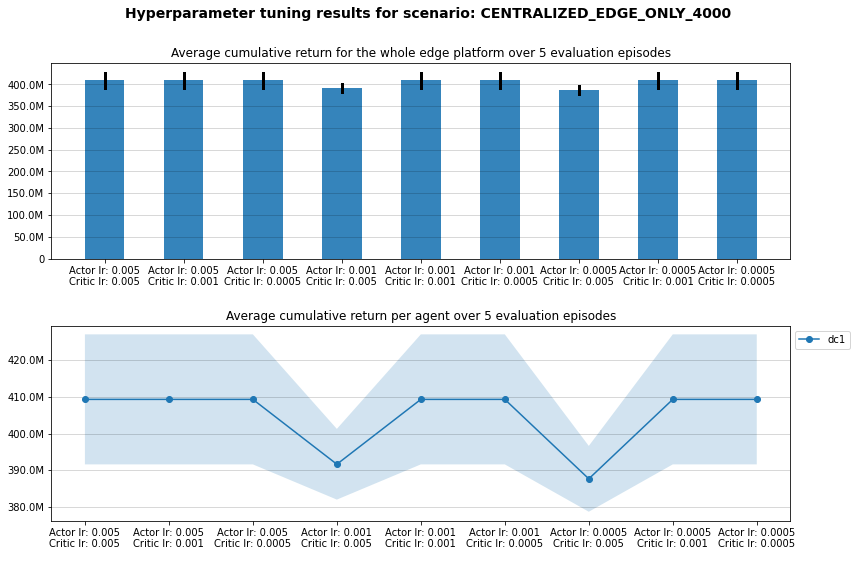

In [4]:
partial_output_dir = path_to_output + 'C_20tuning\output_C_20servers_eval_hparam_'
plot_hyperparam_tuning_results(hyperparams, partial_output_dir, save_plots, path_to_output + 'C_20tuning')

### Centralized 100 servers

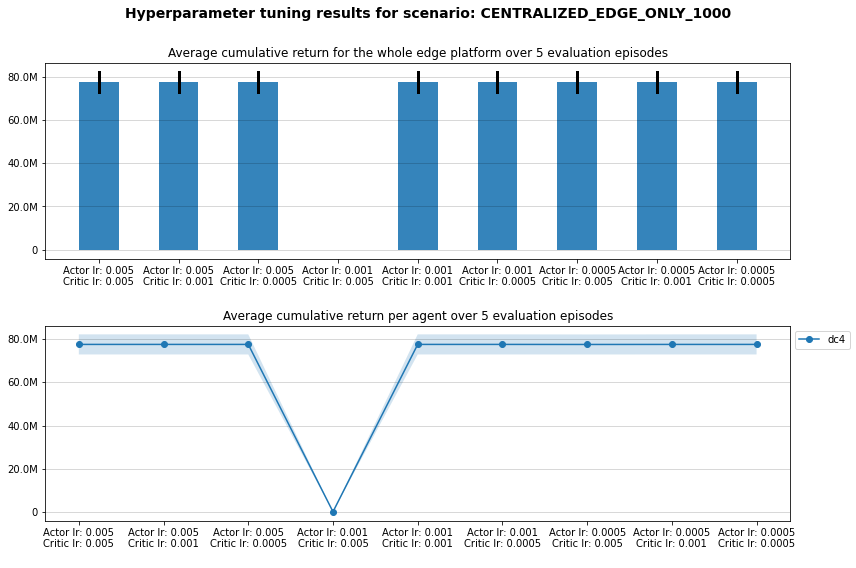

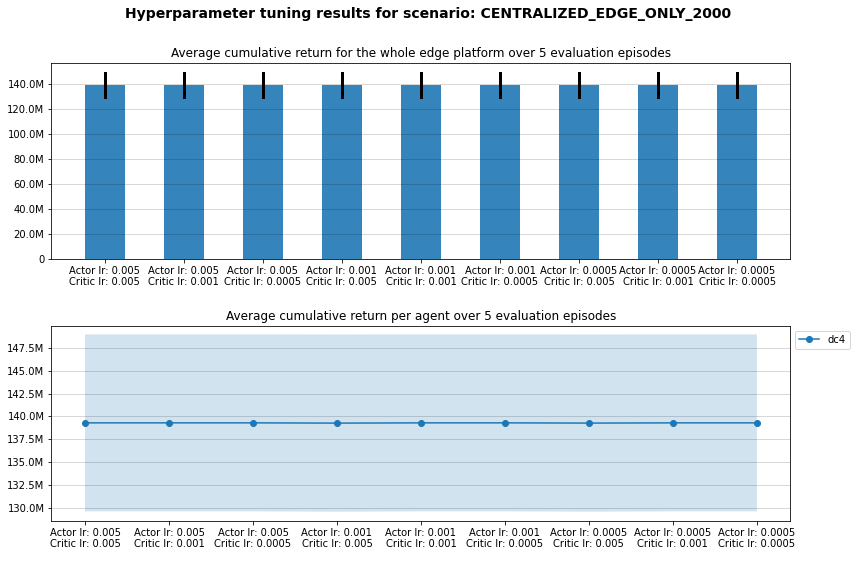

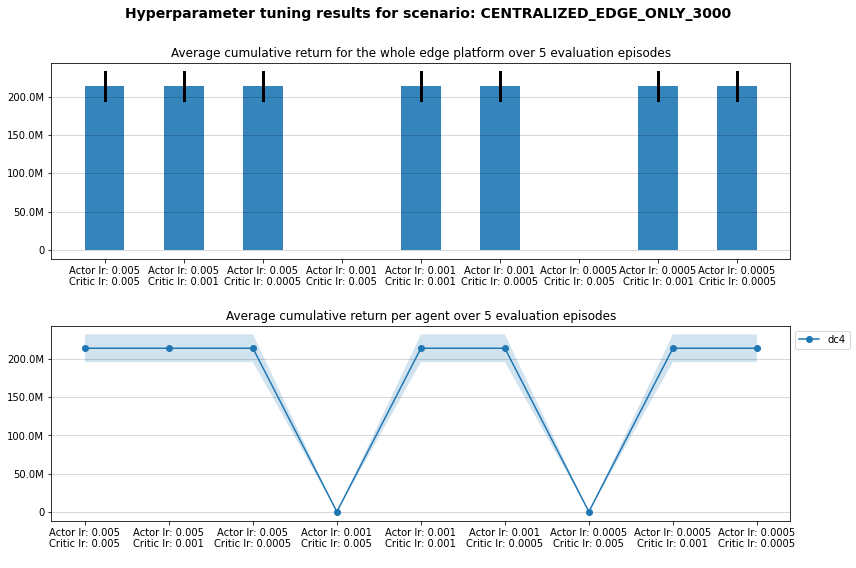

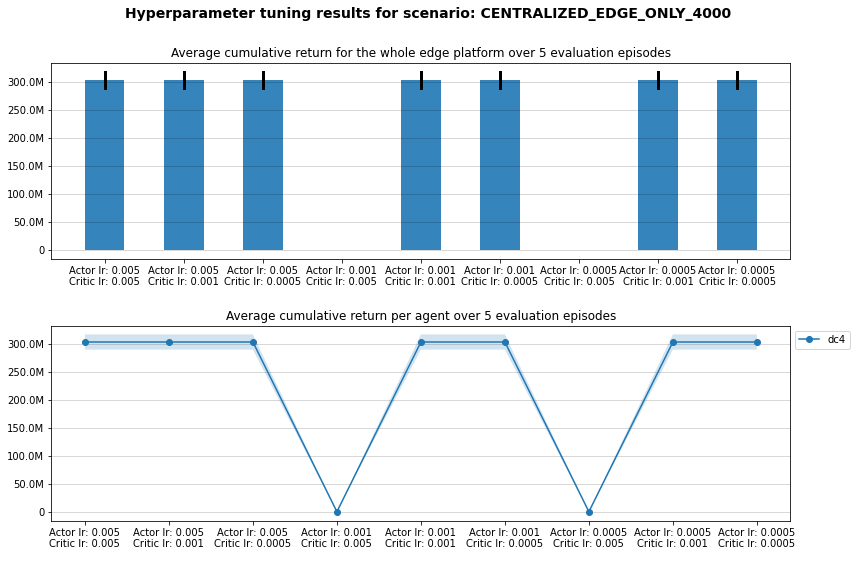

In [5]:
partial_output_dir = path_to_output + 'C_100tuning\output_C_100servers_eval_hparam_'
plot_hyperparam_tuning_results(hyperparams, partial_output_dir, save_plots, path_to_output + 'C_100tuning')

### Hybrid 20 servers

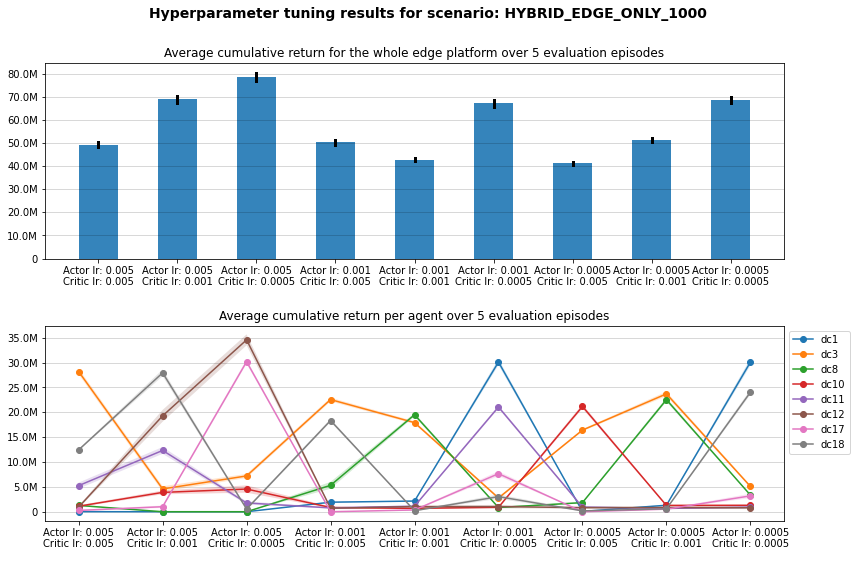

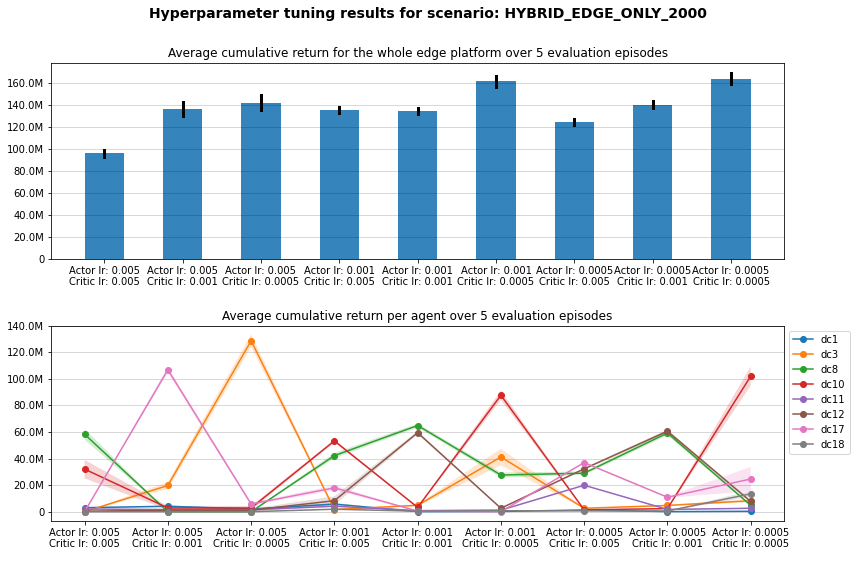

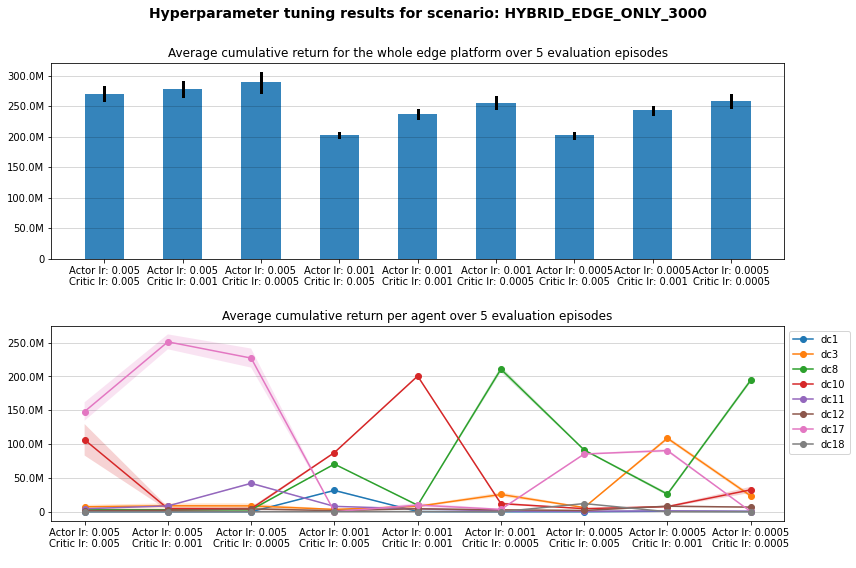

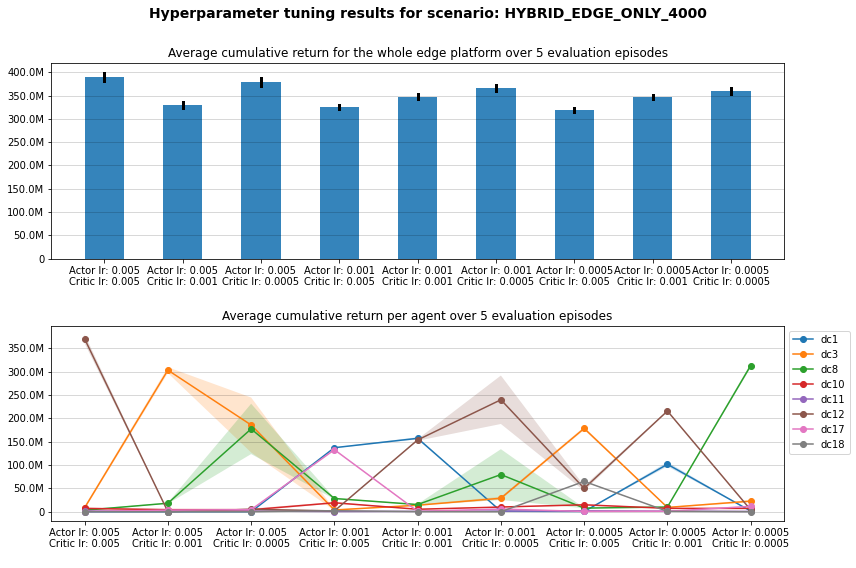

In [6]:
partial_output_dir = path_to_output + 'H_20tuning\output_H_20servers_eval_hparam_'
plot_hyperparam_tuning_results(hyperparams, partial_output_dir, save_plots, path_to_output + 'H_20tuning')

### Hybrid 100 servers

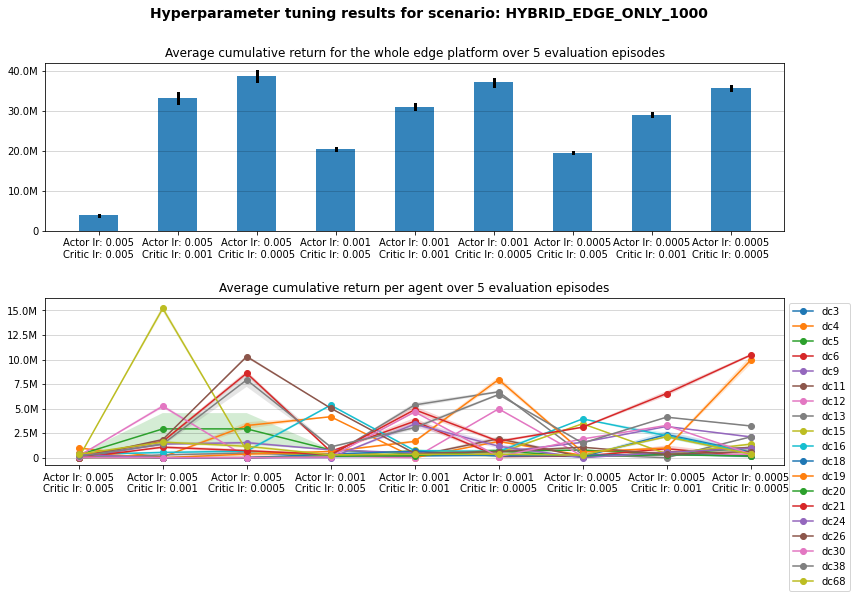

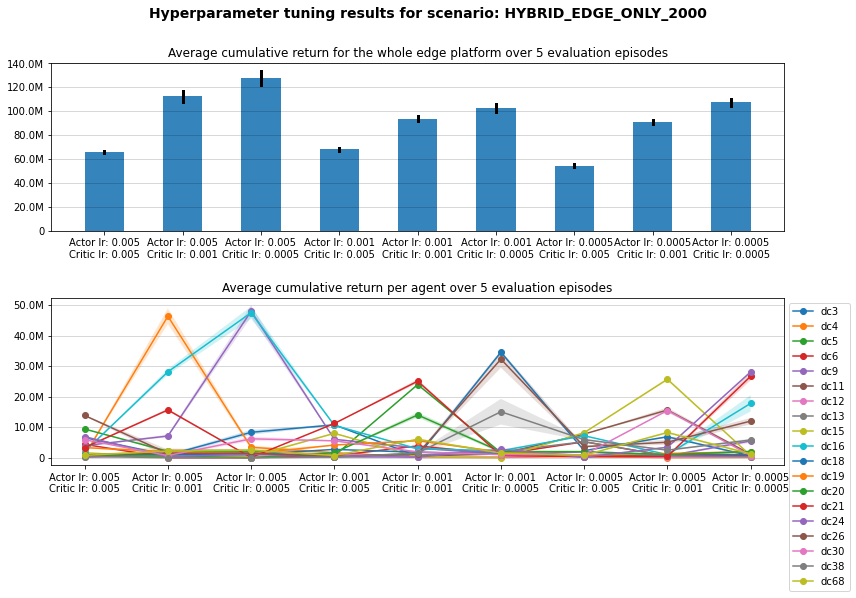

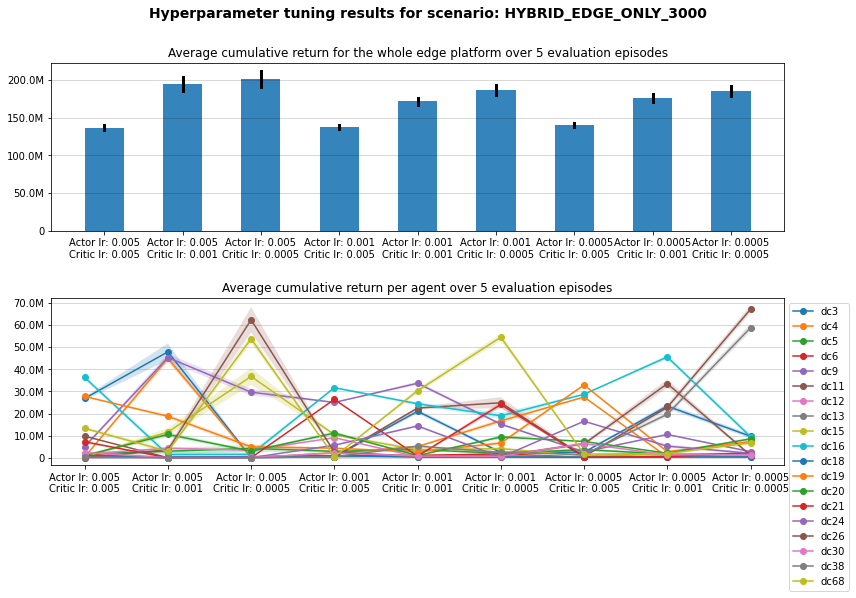

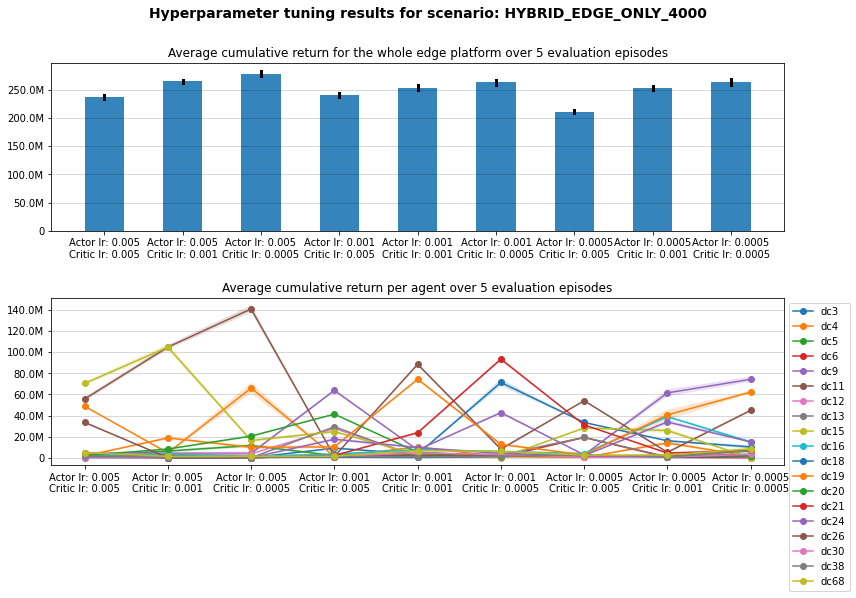

In [7]:
partial_output_dir = path_to_output + 'H_100tuning\output_H_100servers_eval_hparam_'
plot_hyperparam_tuning_results(hyperparams, partial_output_dir, save_plots, path_to_output + 'H_100tuning')

### Decentralized 20 servers

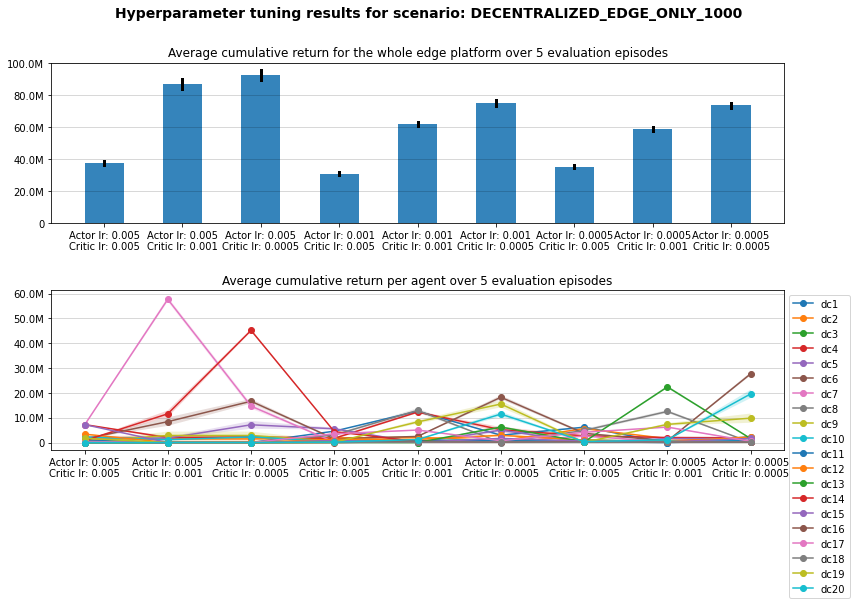

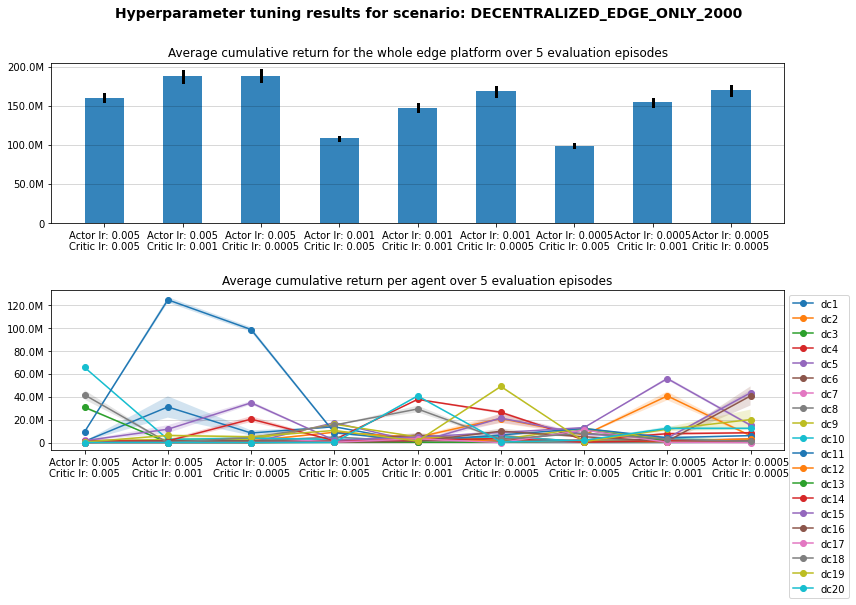

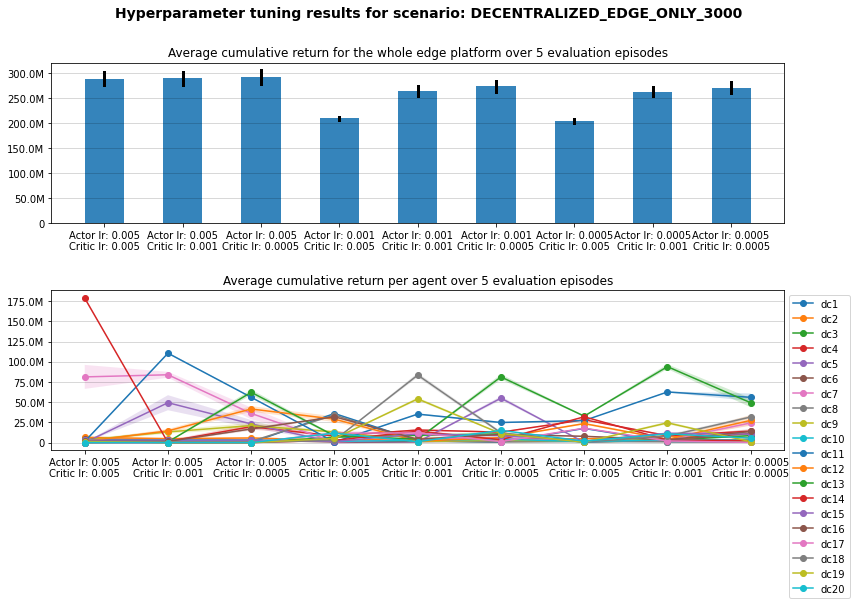

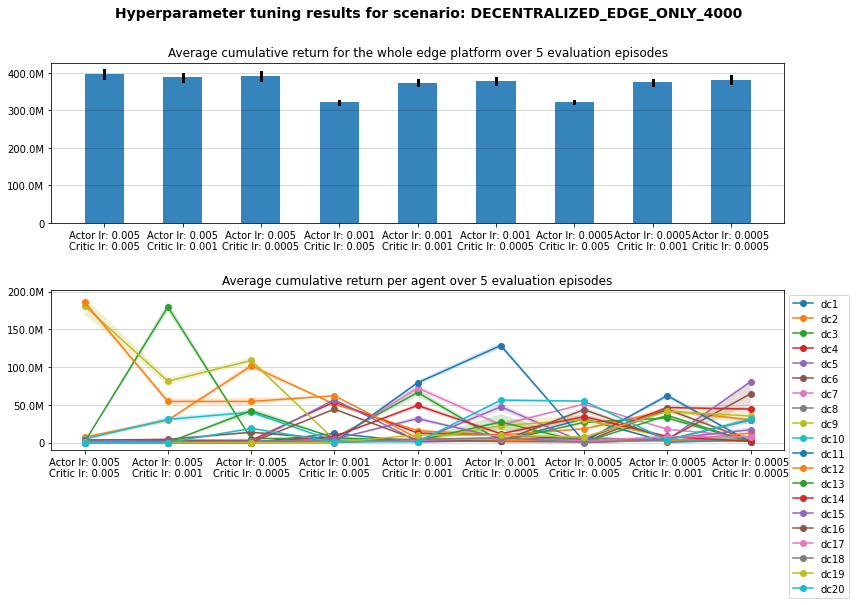

In [8]:
partial_output_dir = path_to_output + 'D_20tuning\output_D_20servers_eval_hparam_'
plot_hyperparam_tuning_results(hyperparams, partial_output_dir, save_plots, path_to_output + 'D_20tuning')

### Decentralized 100 servers

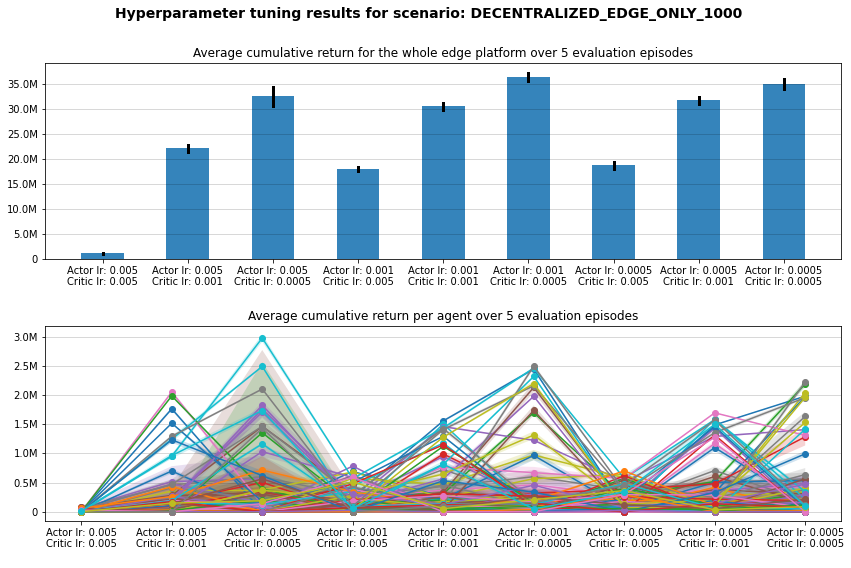

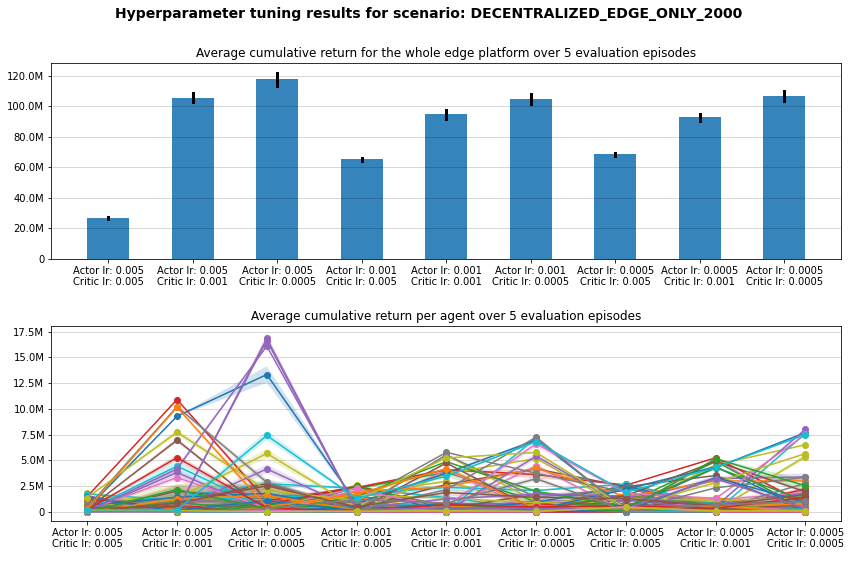

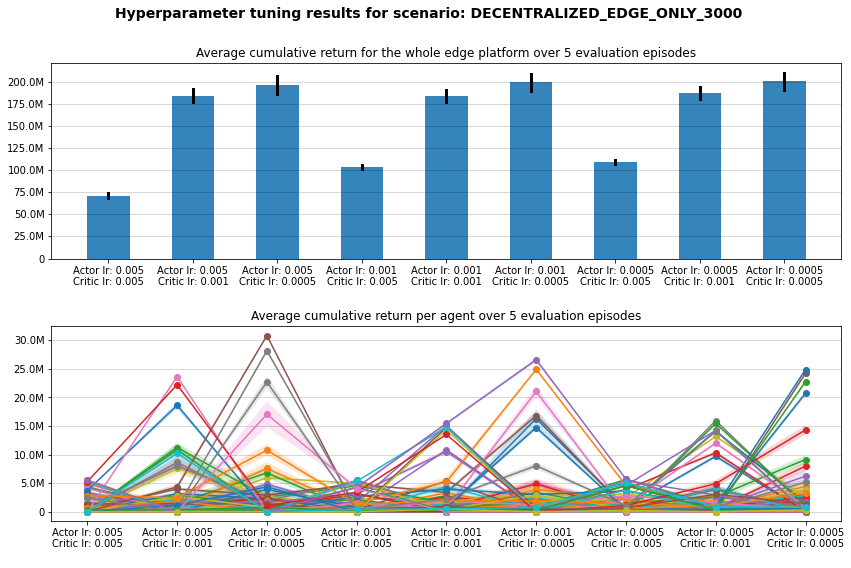

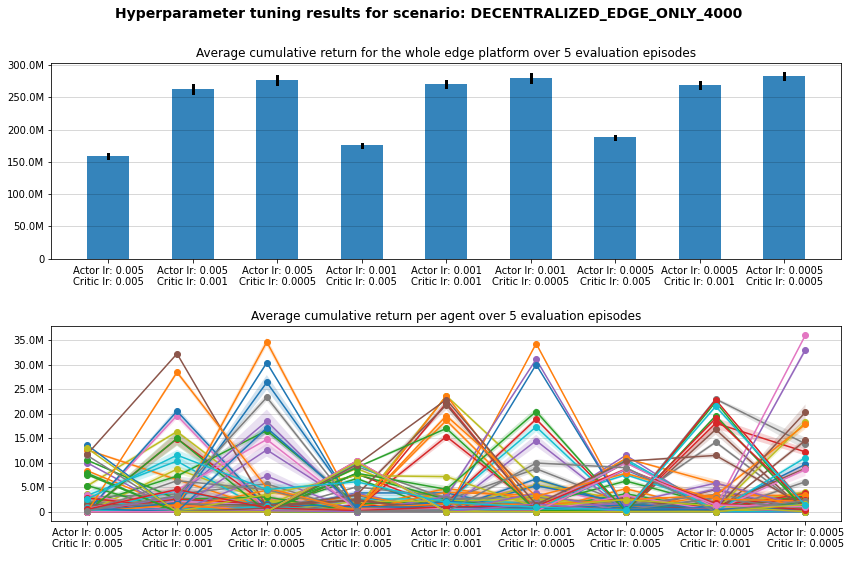

In [9]:
partial_output_dir = path_to_output + 'D_100tuning\output_D_100servers_eval_hparam_'
plot_hyperparam_tuning_results(hyperparams, partial_output_dir, save_plots, path_to_output + 'D_100tuning')